<a href="https://colab.research.google.com/github/lifeisbeautifu1/learning-pytorch/blob/main/Understaning_how_nn_learns_with_backpropagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Understanding NN and backpropagation
### Thanks to Andrej Karpathy
https://www.youtube.com/watch?v=VMj-3S1tku0

In [6]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def f(x):
  return 3*x**2 - 4*x + 5

In [5]:
f(3.0)

20.0

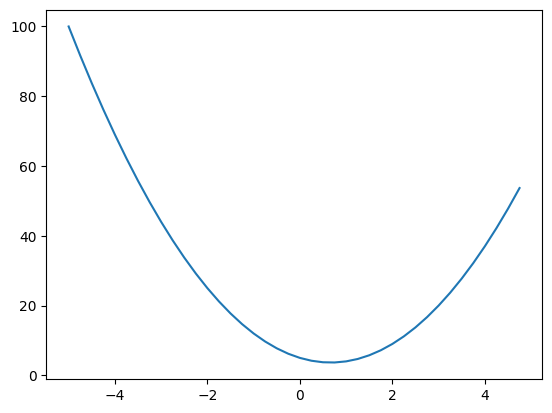

In [7]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [9]:
h = 0.001
x = 3.0
(f(x + h) - f(x)) / h

14.00300000000243

In [11]:
h = 0.001
x = -3.0
(f(x + h) - f(x)) / h

-21.996999999998934

In [12]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [13]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
a += h
d2 = a * b + c

print("d1", d1)
print("d2", d2)
print("slope: ", (d2 - d1) / h)

d1 4.0
d2 3.999699999999999
slope:  -3.000000000010772


In [14]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
b += h
d2 = a * b + c

print("d1", d1)
print("d2", d2)
print("slope: ", (d2 - d1) / h)

d1 4.0
d2 4.0002
slope:  2.0000000000042206


In [15]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
c += h
d2 = a * b + c

print("d1", d1)
print("d2", d2)
print("slope: ", (d2 - d1) / h)

d1 4.0
d2 4.0001
slope:  0.9999999999976694


In [233]:
from pygments.token import Other
class Value:
  def __init__(self, data: float, _children=(), _op="", label=""):
    self.data = data
    self._prev = set(_children)
    self._op = _op
    self._backward = lambda: None
    self.grad = 0.0
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data} | Label: {self.label})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out
  def __rmul__(self, other):
    return self * other
  def __radd__(self, other):
    return self + other
  def __truediv__(self, other):
    return self * other ** -1
  def __neg__(self):
    return self * -1
  def __sub__(self, other):
    return self + (-other)
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data ** other, (self, ), f"**{Other}")

    def _backward():
      self.grad += other * self.data ** (other - 1) * out.grad
    out._backward = _backward;
    return out;

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out


  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), "tanh")

    def _backward():
      self.grad += (1 - t ** 2) * out.grad
    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [159]:
a = Value(2.0, label='a')
b = Value(-3.0, label="b")
a, b

(Value(data=2.0), Value(data=-3.0))

In [160]:
a + b

Value(data=-1.0)

In [161]:
e = a * b
e.label = "e"

In [162]:
c = Value(10.0, label="c")
d = e + c
d.label = "d"

In [163]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [164]:
d._op

'+'

### Some visualization won't hurt

In [165]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

In [166]:
def draw_dot(root):
  dot = Digraph(format="svg", graph_attr={"rankdir": 'LR'})

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))

    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape="record")
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)
  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)
  return dot


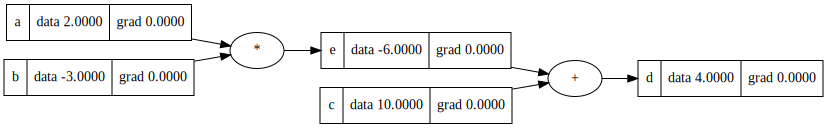

In [167]:
draw_dot(d)

In [168]:
f = Value(-2.0, label="f")
L = d * f
L.label = "L"

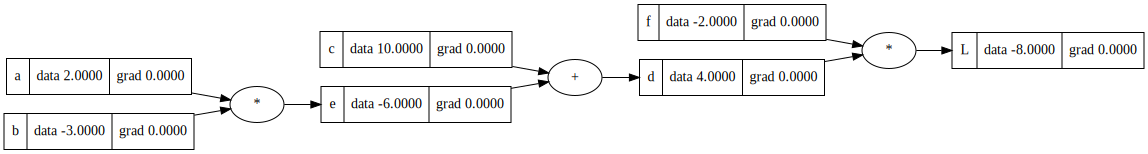

In [169]:
draw_dot(L)

In [170]:
L.grad = 1.0

In [171]:
f.grad = 4.0
d.grad = -2.0

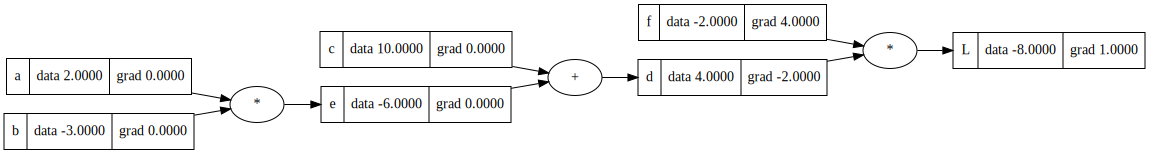

In [172]:
draw_dot(L)

In [173]:
c.grad = -2.0
e.grad = -2.0

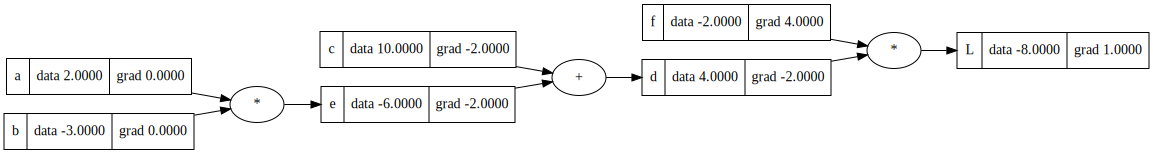

In [174]:
draw_dot(L)

In [175]:
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

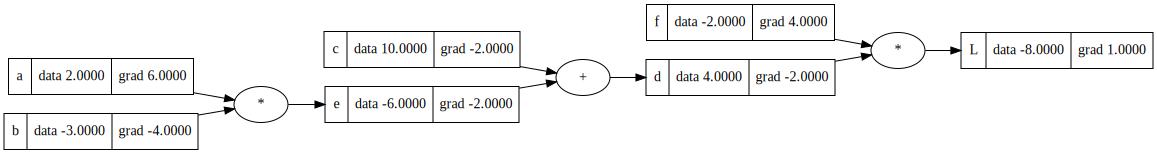

In [176]:
draw_dot(L)

In [177]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

c = a * b
d = e + c
L = d * f

L

Value(data=24.034304)

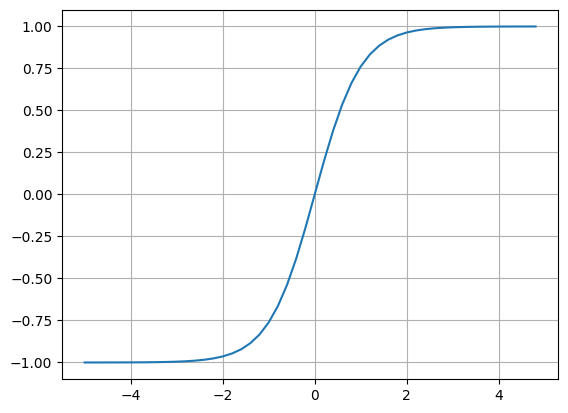

In [178]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()

In [210]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

b = Value(6.88137358, label="b")
x1w1 = x1 * w1
x1w1.label = "x1 * w1"
x2w2 = x2 * w2
x2w2.label = "x2 * w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1 * w1 + x2 * w2"
n = x1w1x2w2 + b
o = n.tanh()
o.label = "o"
n.label = "n"

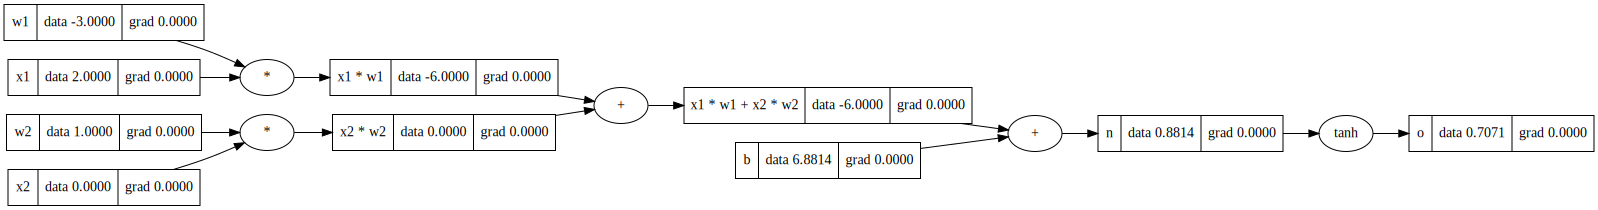

In [199]:
draw_dot(o)

In [181]:
o.grad = 1.0
n.grad = 0.5
b.grad = 0.5
x1w1x2w2.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

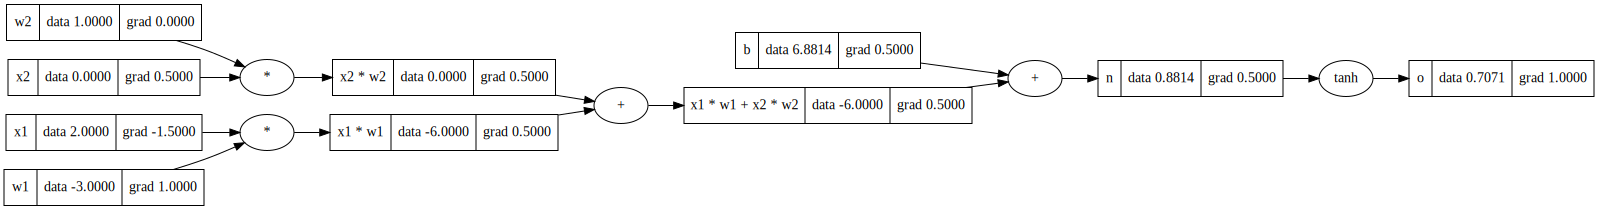

In [195]:
draw_dot(o)

In [200]:
o.grad = 1.0
o._backward()
o.grad

1.0

In [201]:
n._backward()

In [202]:
b._backward()
x1w1x2w2._backward()

In [203]:
x1w1._backward()
x2w2._backward()

### DFS



In [204]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo


[Value(data=1.0 | Label: w2),
 Value(data=0.0 | Label: x2),
 Value(data=0.0 | Label: x2 * w2),
 Value(data=-3.0 | Label: w1),
 Value(data=2.0 | Label: x1),
 Value(data=-6.0 | Label: x1 * w1),
 Value(data=-6.0 | Label: x1 * w1 + x2 * w2),
 Value(data=6.88137358 | Label: b),
 Value(data=0.88137358 | Label: n),
 Value(data=0.707106777676776 | Label: o)]

In [205]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

b = Value(6.88137358, label="b")
x1w1 = x1 * w1
x1w1.label = "x1 * w1"
x2w2 = x2 * w2
x2w2.label = "x2 * w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1 * w1 + x2 * w2"
n = x1w1x2w2 + b
o = n.tanh()
o.label = "o"
n.label = "n"

In [206]:
o.grad = 1.0

In [207]:
topo = []
build_topo(o)

for node in reversed(topo):
  node._backward()

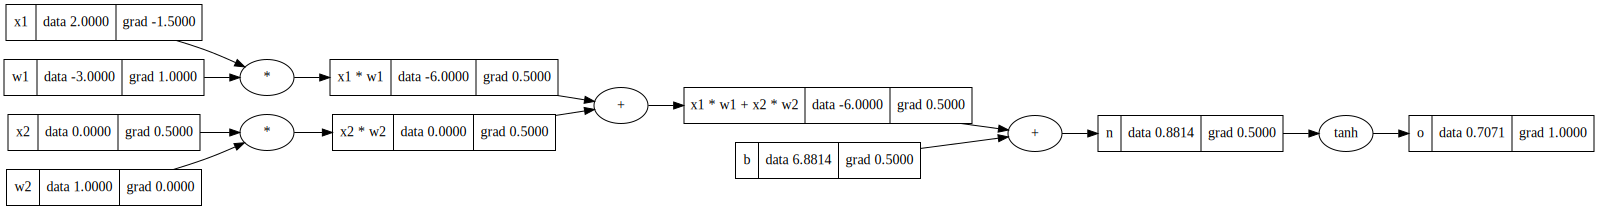

In [208]:
draw_dot(o)

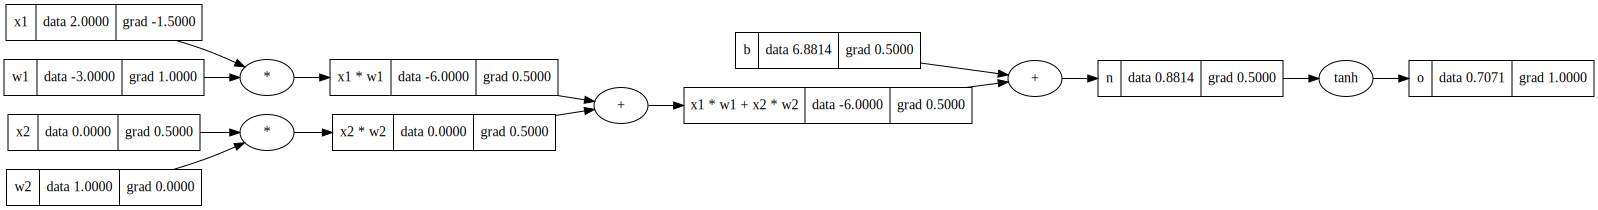

In [211]:
o.backward()
draw_dot(o)

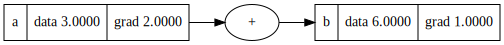

In [215]:
a = Value(3.0, label="a")
b = a + a;
b.label = "b"
b.backward()
draw_dot(b)

In [221]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

b = Value(6.88137358, label="b")
x1w1 = x1 * w1
x1w1.label = "x1 * w1"
x2w2 = x2 * w2
x2w2.label = "x2 * w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1 * w1 + x2 * w2"
n = x1w1x2w2 + b
o = n.tanh()
o.label = "o"
n.label = "n"

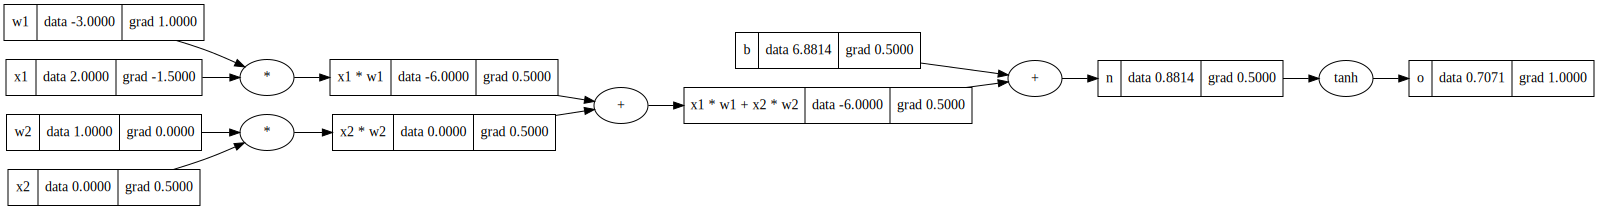

In [222]:
o.backward()
draw_dot(o)

In [225]:
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

b = Value(6.88137358, label="b")
x1w1 = x1 * w1
x1w1.label = "x1 * w1"
x2w2 = x2 * w2
x2w2.label = "x2 * w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1 * w1 + x2 * w2"
n = x1w1x2w2 + b
#
e = (2 * n).exp()
o = (e - 1) / (e + 1)
#
o.label = "o"
n.label = "n"

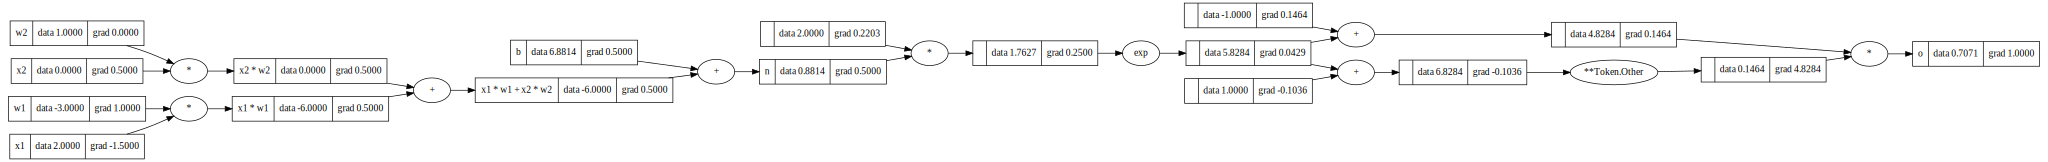

In [226]:
o.backward()
draw_dot(o)

### Same thing in PyTorch

In [229]:
import torch

x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.88137358]).double()
b.requires_grad = True

n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()


print("------")
print("x1", x1.grad.item())
print("w1", w1.grad.item())
print("x2", x2.grad.item())
print("w2", w2.grad.item())

0.7071066904050358
------
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
w2 0.0


In [230]:
import random

NN



In [268]:
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
    return act.tanh()

  def parameters(self):
    return self.w + [self.b]

In [241]:
x = [2.0, 3.0]
n = Neuron(2)
n(x)

Value(data=-0.7601625239840941 | Label: )

In [270]:
class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]
    # params = []
    # for neuron in self.neurons:
    #   ps = neuron.parameters()
    #   params.extend(ps)
    # return params

In [272]:
x = [2.0, 3.0]
n = Layer(2, 3)
n(x)

[Value(data=-0.7632437251697507 | Label: ),
 Value(data=-0.990354463154628 | Label: ),
 Value(data=0.9998305676281387 | Label: )]

In [273]:
n.parameters()

[Value(data=-0.7178756873214607 | Label: ),
 Value(data=0.16429556460151762 | Label: ),
 Value(data=-0.06107490999118337 | Label: ),
 Value(data=-0.7845255198309637 | Label: ),
 Value(data=-0.6834425392581887 | Label: ),
 Value(data=0.9545922980605868 | Label: ),
 Value(data=0.8317154332981329 | Label: ),
 Value(data=0.7576846753041842 | Label: ),
 Value(data=0.7515746862984503 | Label: )]

In [271]:
class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [275]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)
n.parameters()

[Value(data=-0.29312887387753706 | Label: ),
 Value(data=-0.3234902728767932 | Label: ),
 Value(data=0.05250550889978167 | Label: ),
 Value(data=-0.02015558615052182 | Label: ),
 Value(data=-0.6215787603398619 | Label: ),
 Value(data=0.636338401372071 | Label: ),
 Value(data=0.3933791202203234 | Label: ),
 Value(data=-0.1240399706588291 | Label: ),
 Value(data=0.121973848453371 | Label: ),
 Value(data=-0.014670347862156152 | Label: ),
 Value(data=0.27152220081583334 | Label: ),
 Value(data=0.7283895392253883 | Label: ),
 Value(data=0.7512782711161266 | Label: ),
 Value(data=-0.4584821471828757 | Label: ),
 Value(data=0.9828643446838932 | Label: ),
 Value(data=-0.28406667234380456 | Label: ),
 Value(data=-0.482841828511146 | Label: ),
 Value(data=-0.8182170761459324 | Label: ),
 Value(data=-0.5711987865942507 | Label: ),
 Value(data=-0.7221429807188156 | Label: ),
 Value(data=-0.08850687314699601 | Label: ),
 Value(data=0.05657701318988795 | Label: ),
 Value(data=0.04031316717500322 | L

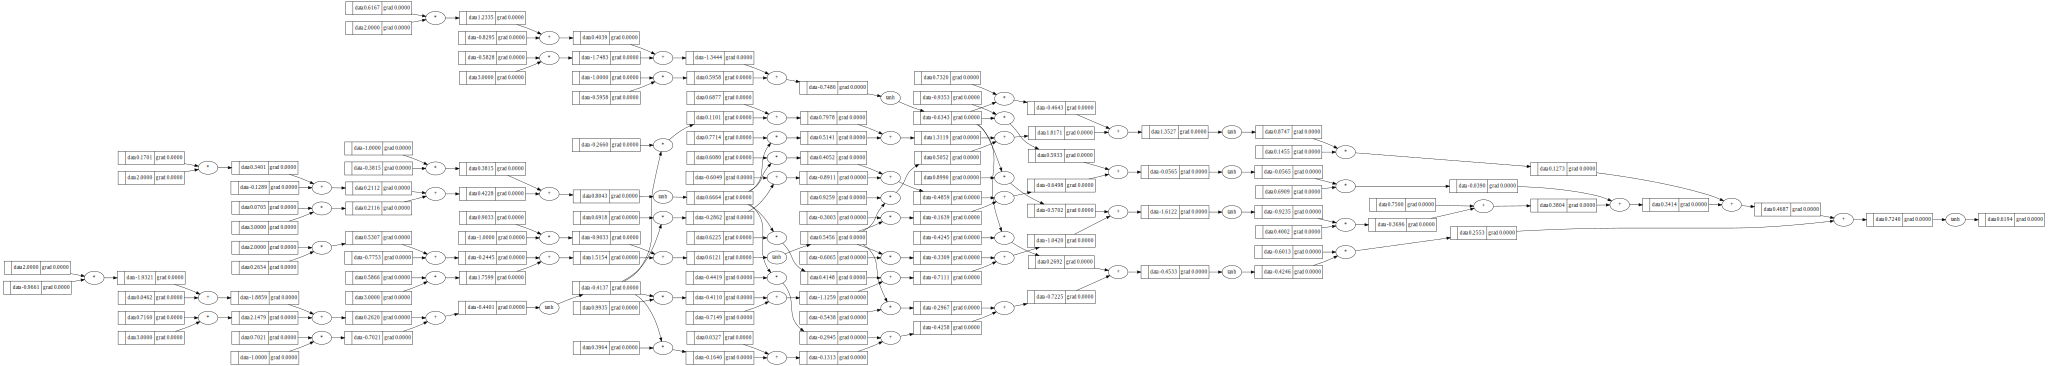

In [253]:
draw_dot(n(x))

In [276]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [277]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.8862079504376146 | Label: ),
 Value(data=0.07600063743277817 | Label: ),
 Value(data=0.9172045450580517 | Label: ),
 Value(data=0.5173352920875524 | Label: )]

In [278]:
loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=5.079364490154813 | Label: )

In [279]:
loss.backward()

In [280]:
n.layers[0].neurons[0].w[0].grad

0.40461768461984127

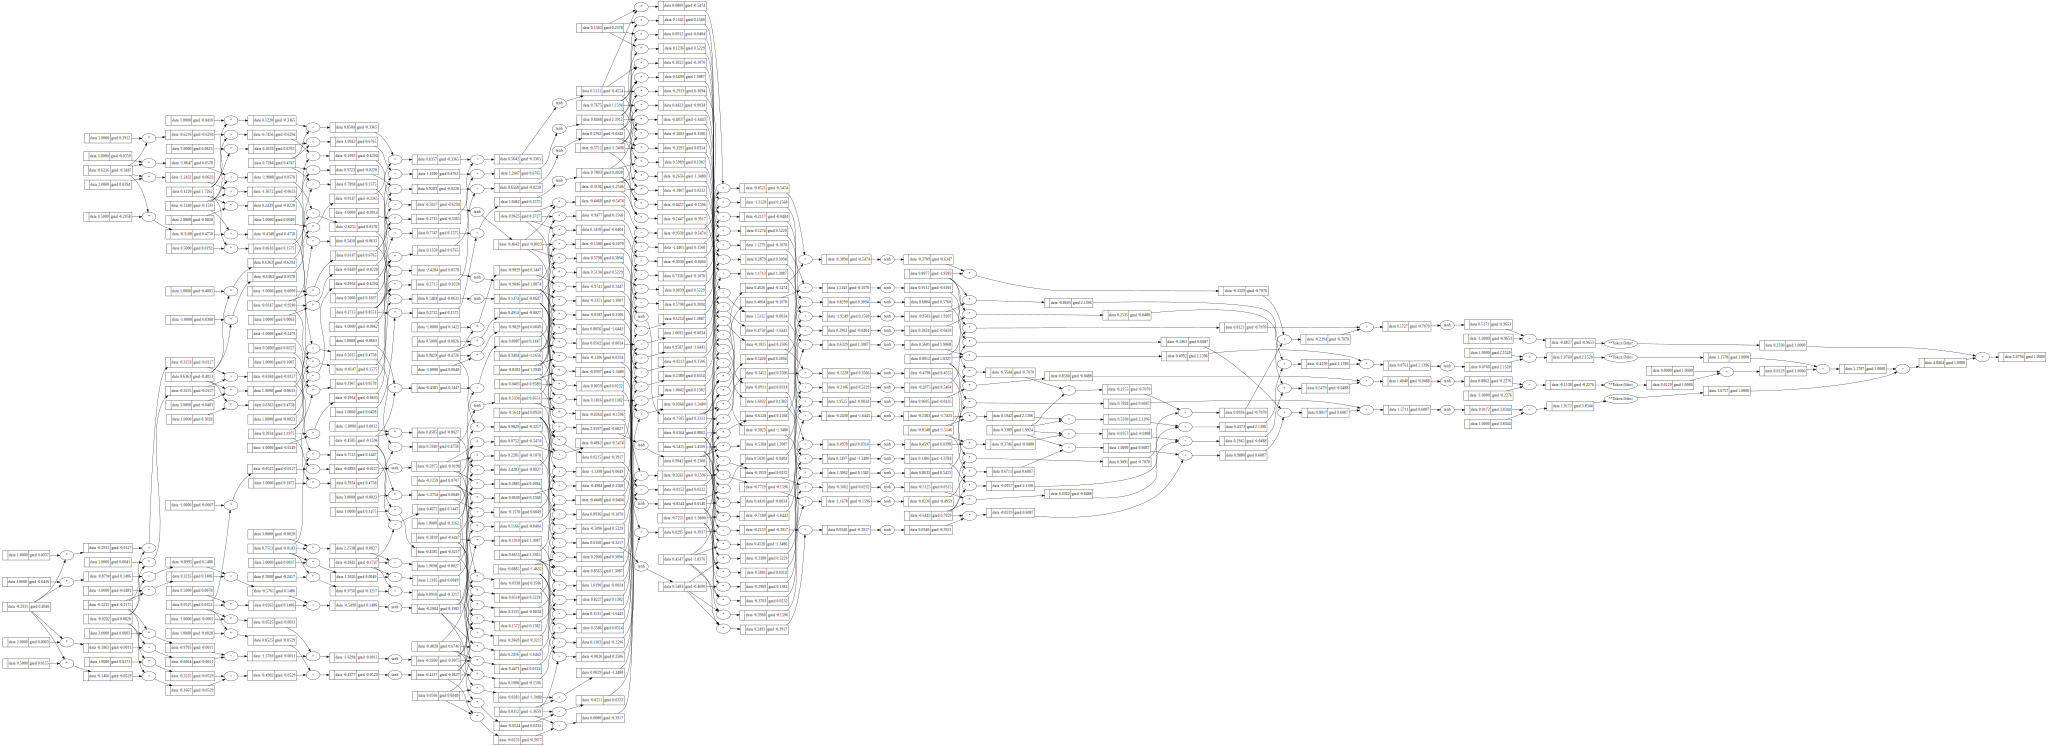

In [281]:
draw_dot(loss)

In [283]:
n.layers[0].neurons[0].w[0].data

-0.29717505072373546

In [284]:
for p in n.parameters():
  p.data += -0.01 * p.grad

In [285]:
n.layers[0].neurons[0].w[0].data

-0.30122122756993386

In [286]:
loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=5.079364490154813 | Label: )

In [287]:
loss.backward()

In [288]:
for p in n.parameters():
  p.data += -0.01 * p.grad

In [289]:
n.layers[0].neurons[0].w[0].data

-0.4243265479759356

In [291]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9425969013347585 | Label: ),
 Value(data=-0.976425033318363 | Label: ),
 Value(data=0.3467789363165325 | Label: ),
 Value(data=0.5700738951530236 | Label: )]

In [292]:
loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=2.002500853725196 | Label: )

### Learning


In [309]:
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=0.021957416644822314 | Label: )

In [310]:
loss.backward()

In [311]:
for p in n.parameters():
  p.data += -0.01 * p.grad

In [312]:
ypred

[Value(data=0.8886793862144784 | Label: ),
 Value(data=-0.9985642434700847 | Label: ),
 Value(data=-0.9977648363098354 | Label: ),
 Value(data=0.9022345652201044 | Label: )]

In [315]:
ys

[1.0, -1.0, -1.0, 1.0]

In [316]:
n.parameters()

[Value(data=-1.0399266145911596 | Label: ),
 Value(data=0.0020470554582404515 | Label: ),
 Value(data=-0.06954786334502933 | Label: ),
 Value(data=-0.21201646642592442 | Label: ),
 Value(data=-0.27814079983248396 | Label: ),
 Value(data=0.9541399754422581 | Label: ),
 Value(data=-0.9051285869744952 | Label: ),
 Value(data=-0.04890692854915142 | Label: ),
 Value(data=-1.4642264589218892 | Label: ),
 Value(data=0.7588610762241701 | Label: ),
 Value(data=-0.47484869405455477 | Label: ),
 Value(data=0.29874603014014633 | Label: ),
 Value(data=0.7762475934603684 | Label: ),
 Value(data=-0.2706001127652173 | Label: ),
 Value(data=1.4579867325088873 | Label: ),
 Value(data=-0.08171085676929882 | Label: ),
 Value(data=-1.0674502769465914 | Label: ),
 Value(data=-1.886112085802422 | Label: ),
 Value(data=0.43182062094652346 | Label: ),
 Value(data=0.6422262063792836 | Label: ),
 Value(data=1.0994943975692457 | Label: ),
 Value(data=-0.44037801993102743 | Label: ),
 Value(data=-0.647352280612301

In [319]:
for k in range(100):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum([(yout - ygt) ** 2 for ygt, yout in zip(ys, ypred)])
  # zero grad
  for p in n.parameters():
    p.grad = 0.0
  # backward pass
  loss.backward()
  # update
  for p in n.parameters():
    p.data += -0.01 * p.grad
  print(k, loss.data)


0 2.492689864557218e-18
1 2.492689864557218e-18
2 2.492689864557218e-18
3 2.492689864557218e-18
4 2.492689864557218e-18
5 2.492689864557218e-18
6 2.492689864557218e-18
7 2.492689864557218e-18
8 2.492689864557218e-18
9 2.492689864557218e-18
10 2.492689864557218e-18
11 2.492689864557218e-18
12 2.492689864557218e-18
13 2.492689864557218e-18
14 2.492689864557218e-18
15 2.492689864557218e-18
16 2.492689864557218e-18
17 2.492689864557218e-18
18 2.492689864557218e-18
19 2.492689864557218e-18
20 2.492689864557218e-18
21 2.492689864557218e-18
22 2.492689864557218e-18
23 2.492689864557218e-18
24 2.492689864557218e-18
25 2.492689864557218e-18
26 2.492689864557218e-18
27 2.492689864557218e-18
28 2.492689864557218e-18
29 2.492689864557218e-18
30 2.492689864557218e-18
31 2.492689864557218e-18
32 2.492689864557218e-18
33 2.492689864557218e-18
34 2.492689864557218e-18
35 2.492689864557218e-18
36 2.492689864557218e-18
37 2.492689864557218e-18
38 2.492689864557218e-18
39 2.492689864557218e-18
40 2.49268

In [320]:
ys, ypred

([1.0, -1.0, -1.0, 1.0],
 [Value(data=0.9999999988836018 | Label: ),
  Value(data=-1.0 | Label: ),
  Value(data=-1.0 | Label: ),
  Value(data=0.9999999988836018 | Label: )])